# Lokalisieren von Verkehrsschildern

Für das Lokalisieren von Objekten in Bildern werden überlicherweise Region Based Convolutional Neural Networks (R-CNNs) verwendendet. Diese Methode wurde mit der Zeit verbessert:
* November 2013: R-CNN
* April 2015: Fast R-CNN
* Juni 2015: Faster R-CNN
* März 2017: Mask R-CNN
* Juni 2019: Mesh R-CNN

Diese und weitere Ansätze und Algorithmen werden in verschiedenen Frameworks benutzt. Eines davon ist YOLO, welches später benutzt wird.

Im Folgenden wird mithilfe von Bounding Box Regression ein Maschine Learning Modell entwickelt, welches die Position in Form von Bounding Boxes von Verkehrsschildern erkennt.

Beispiel Bounding Box:
    TODO

## Image Generator

Da die vorliegenden Trainingsbilder bereits auf die Verkehrsschilder zugeschnitten sind und lediglich 10% Rand um diese aufweisen, wurde sich dazu entschieden syntetische Trainingsdaten aus den vorhandenen Trainingsbildern und neuen Hintergrundbildern zu generieren. \
Dafür wurde eine die Funktion\
generate_raster_sign_image(
*    number_of_images,
*    number_of_signs,
*    path_to_bg_img_folder,
*    pre_path_sign,
*    sign_size,
*    raster_width,
*    raster_height,
*    sign_with_clahe,
*    verbose=False,
*    show_images=False)

erstellt. Diese verwendet die beiden neu programmierten Funktionen *_get_random_signs()* und *_get_bg_images()* um zufällige Verkehrsschilder rasterförmig zufällig verteilt auf Hintergrundbilder zu platzieren.

Beispielbilder generate_raster_sign_image:
    TODO

Neben den generierten Bildern werden auch die Boundings Boxes und Labels als Liste von Dictionarys zurückgegeben. Keys: Bounding Boxes als Tuple und Classifier als Value.

## Imports

In [1]:
import sys
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
from reader import Reader
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import cv2
import os
from skimage import exposure, transform
import pickle
import tensorflow as tf

## Training mit einem Verkehrszeichen pro Bild

### Vorverarbeitung

In [2]:
file = open(r"/home/soeren/uni/maschine-learning/repo/pickle/data_1.pickle", 'rb')
data = pickle.load(file)
file.close()
file = open(r"/home/soeren/uni/maschine-learning/repo/pickle/labels_1.pickle", 'rb')
labels = pickle.load(file)
file.close()

In [3]:
input_shape = data[0].shape

In [4]:
targets = []
for k in labels:
    e = next(iter(k)) #first BB is the only one
    x1, y1, x2, y2 = e #extract coordinates
    h, w = input_shape[:2]
    x1 = x1/w #scale with image shape
    y1 = y1/h
    x2 = x2/w
    y2 = y2/h
    targets.append((x1, y1, x2, y2))
    
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

### Aufteilen der Daten zu Trainings, Validierungs und Testdaten

In [7]:
split = train_test_split(data, targets, test_size=0.25, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

split = train_test_split(testImages, testTargets, test_size=0.5, random_state=42)

(validationImages, testImages) = split[:2]
(validationTargets, testTargets) = split[2:4]

### Modell erstellen

In [8]:
input_layer = Input(input_shape)

#create the base layers
base_layers = Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(input_layer)
base_layers = MaxPooling2D(name='bl_3')(base_layers)
base_layers = Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = MaxPooling2D(name='bl_5')(base_layers)
base_layers = Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = MaxPooling2D(name='bl_7')(base_layers)
base_layers = Flatten(name='bl_8')(base_layers)

#create the localiser branch
locator_branch = Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

model = tf.keras.Model(input_layer, outputs=locator_branch)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 96, 3)]       0         
                                                                 
 bl_2 (Conv2D)               (None, 64, 96, 16)        448       
                                                                 
 bl_3 (MaxPooling2D)         (None, 32, 48, 16)        0         
                                                                 
 bl_4 (Conv2D)               (None, 32, 48, 32)        4640      
                                                                 
 bl_5 (MaxPooling2D)         (None, 16, 24, 32)        0         
                                                                 
 bl_6 (Conv2D)               (None, 16, 24, 64)        18496     
                                                                 
 bl_7 (MaxPooling2D)         (None, 8, 12, 64)         0   

In [9]:
loss = tf.keras.losses.MAE

In [10]:
model.compile(loss=loss, optimizer='Adam')

### Trainig starten

In [11]:
epoch_num = 2

In [21]:
training = model.fit(trainImages, trainTargets,
             validation_data=(testImages, testTargets),
             batch_size=10,
             epochs=epoch_num,
             shuffle=True,
             verbose=1)

Epoch 1/2
   2/1500 [..............................] - ETA: 1:52 - loss: 0.2275

2022-03-13 17:10:30.909928: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4423680000 exceeds 10% of free system memory.


1500/1500 [==============================] - 153s 102ms/step - loss: 0.1844 - val_loss: 0.1933
Epoch 2/2
1500/1500 [==============================] - 188s 125ms/step - loss: 0.1728 - val_loss: 0.1963


### Modell abspeichern

In [22]:
model.save(r"models/models_regr_1_1", save_format="h5")

### Visualieren des Trainings

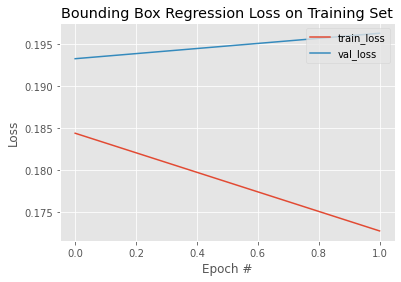

In [23]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epoch_num), training.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch_num), training.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

### Modell aus Datei laden

In [6]:
model = load_model(r"models/models_regr_1_1")

2022-03-14 15:42:58.859598: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Anzeigen von Testbildern

In [ ]:
from src.image_detection import predict_and_display_img

for image, bounding in zip(testImages, testTargets):
    predict_and_display_img(model, image, bounding)

## Training mit mehreren Verkehrsschilder

In [3]:
file = open(r"/home/soeren/uni/maschine-learning/repo/pickle/data_3.pickle", 'rb')
data = pickle.load(file)
file.close()
file = open(r"/home/soeren/uni/maschine-learning/repo/pickle/labels_3.pickle", 'rb')
labels = pickle.load(file)
file.close()

In [4]:
targets = []
input_shape = data[0].shape
for k in labels:
    a = list(k.keys())
    a.sort(key=lambda x: (x[0], x[1])) ## wichtig! Erläuterung: nächste Zelle
    temp = [] #input vektor for model
    for e in a:
        x1, y1, x2, y2 = e #extract coordinates
        h, w = input_shape[:2]
        temp.append(x1/w) #scale with image shape
        temp.append(y1/h)
        temp.append(x2/w)
        temp.append(y2/h)
    targets.append(temp)
    
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

Es ist wichtig, dass das maschine learning modell zwischen den einzelnen verkehrsschildern unterscheiden kann. \
Dafür müssen die Bounding Boxen, bzw. die Koordinaten dieser, für den Eingabevektor immer eine spezielle Reihenfolge haben. \
Um dies zu erreichen wurde sich dazu entschieden, die Boxen nach ihrer X-Koordinaate der oberen linken Ecke zu sortieren. Bei gleichen Werten wird nach der Y-Koordiate entschieden.

Wird keine Sortierung vorgenommen, sieht das Ergebnis wie folgt aus: \
<img src="./images/3_signs_without_sort1.png">     <img src="./images/3_signs_without_sort2.png">\
Grün = Predicted Bounding Box, Rot = actual Bounding Box

In [5]:
split = train_test_split(data, targets, test_size=0.25, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

split = train_test_split(testImages, testTargets, test_size=0.5, random_state=42)

(validationImages, testImages) = split[:2]
(validationTargets, testTargets) = split[2:4]

### Modell erstellen

In [5]:
input_layer = Input(input_shape)

#create the base layers
base_layers = Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(input_layer)
base_layers = MaxPooling2D(name='bl_3')(base_layers)
base_layers = Conv2D(24, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = MaxPooling2D(name='bl_5')(base_layers)
base_layers = Conv2D(32, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = MaxPooling2D(name='bl_7')(base_layers)
base_layers = Conv2D(48, 3, padding='same', activation='relu', name='bl_8')(base_layers)
base_layers = MaxPooling2D(name='bl_9')(base_layers)
base_layers = Conv2D(64, 3, padding='same', activation='relu', name='bl_10')(base_layers)
base_layers = MaxPooling2D(name='bl_11')(base_layers)
base_layers = Conv2D(96, 3, padding='same', activation='relu', name='bl_12')(base_layers)
base_layers = MaxPooling2D(name='bl_13')(base_layers)
base_layers = Conv2D(128, 3, padding='same', activation='relu', name='bl_14')(base_layers)
base_layers = MaxPooling2D(name='bl_15')(base_layers)
base_layers = Flatten(name='bl_18')(base_layers)

#create the localiser branch
locator_branch = Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = Dense(96, activation='relu', name='bb_2')(locator_branch)
locator_branch = Dense(64, activation='relu', name='bb_3')(locator_branch)
locator_branch = Dense(48, activation='relu', name='bb_4')(locator_branch)
locator_branch = Dense(32, activation='relu', name='bb_5')(locator_branch)
locator_branch = Dense(16, activation='relu', name='bb_6')(locator_branch)
locator_branch = Dense(12, activation='sigmoid', name='bb_head')(locator_branch)

model = tf.keras.Model(input_layer, outputs=locator_branch)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 192, 3)]     0         
                                                                 
 bl_2 (Conv2D)               (None, 128, 192, 16)      448       
                                                                 
 bl_3 (MaxPooling2D)         (None, 64, 96, 16)        0         
                                                                 
 bl_4 (Conv2D)               (None, 64, 96, 24)        3480      
                                                                 
 bl_5 (MaxPooling2D)         (None, 32, 48, 24)        0         
                                                                 
 bl_6 (Conv2D)               (None, 32, 48, 32)        6944      
                                                                 
 bl_7 (MaxPooling2D)         (None, 16, 24, 32)        0     

2022-03-15 16:44:02.665451: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
loss = tf.keras.losses.MAE

In [7]:
model.compile(loss=loss, optimizer='Adam')

### Trainig starten

In [8]:
epoch_num = 15

In [9]:
training = model.fit(trainImages, trainTargets,
             validation_data=(testImages, testTargets),
             batch_size=10,
             epochs=epoch_num,
             shuffle=True,
             verbose=1)

2022-03-15 16:44:03.382789: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4423680000 exceeds 10% of free system memory.


Epoch 1/15
1500/1500 [==============================] - 180s 120ms/step - loss: 0.1718 - val_loss: 0.1257
Epoch 2/15
1500/1500 [==============================] - 198s 132ms/step - loss: 0.1160 - val_loss: 0.1115
Epoch 3/15
1500/1500 [==============================] - 202s 135ms/step - loss: 0.1020 - val_loss: 0.0918
Epoch 4/15
1500/1500 [==============================] - 203s 136ms/step - loss: 0.0855 - val_loss: 0.0833
Epoch 5/15
1500/1500 [==============================] - 185s 123ms/step - loss: 0.0812 - val_loss: 0.0815
Epoch 6/15
1500/1500 [==============================] - 187s 125ms/step - loss: 0.0790 - val_loss: 0.0807
Epoch 7/15
1500/1500 [==============================] - 190s 127ms/step - loss: 0.0755 - val_loss: 0.0758
Epoch 8/15
1500/1500 [==============================] - 190s 127ms/step - loss: 0.0709 - val_loss: 0.0637
Epoch 9/15
1500/1500 [==============================] - 196s 131ms/step - loss: 0.0562 - val_loss: 0.0538
Epoch 10/15
1500/1500 [=======================

### Modell abspeichern

In [11]:
model.save(r"models/models_regr_3signs_1", save_format="h5")

### Visualieren des Trainings

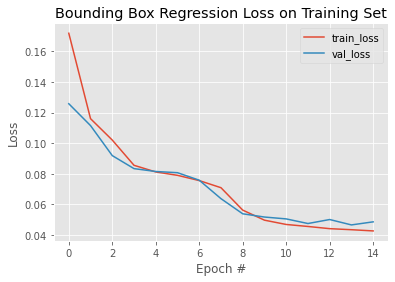

In [13]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epoch_num), training.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch_num), training.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
#plt.show()
plt.savefig('./images/training3_15_1.png')

### Modell aus Datei laden

In [6]:
model = load_model(r"models/models_regr_3signs_1")

2022-03-15 17:58:01.936703: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Anzeigen von Testbildern

In [7]:
from src.image_detection import predict_and_display_img

for image, bounding in zip(testImages, testTargets):
    predict_and_display_img(model, image, bounding)

qt.qpa.xcb: QXcbConnection: XCB error: 3 (BadWindow), sequence: 2220, resource id: 8881762, major code: 40 (TranslateCoords), minor code: 0
qt.qpa.xcb: QXcbConnection: XCB error: 3 (BadWindow), sequence: 3630, resource id: 8951028, major code: 40 (TranslateCoords), minor code: 0


KeyboardInterrupt: 

In [8]:
cv2.destroyAllWindows()

<img src="./images/3_signs_2.png">     <img src="./images/3_signs_3.png">